In [1]:
import numpy as np
import time
import math
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.cross_validation import cross_val_score, KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn import neighbors
import random
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style="whitegrid", color_codes=True, context="poster")

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Tools

In [2]:
def kmeans_labels(data,k=10):
    # inicializa KMeans con k clusters y 10 iteraciones.
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    # fit de los datos
    kmeans.fit(data)
    # obtiene los centros de los k clusters
    center_list = kmeans.cluster_centers_
    # return labels per instance and the center of the centroids
    return kmeans.labels_.tolist(), center_list

def plot_with_errbars(N, data):
    x = np.arange(N)
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    valid = ~np.isnan(mean)
    plt.fill_between(x[valid], (mean-2*std)[valid], (mean+2*std)[valid], color='#d0d0d0')
    plt.plot(x[valid], mean[valid])
# return the pair with longest distrance in a batch of samples
def angular_distance_N_whole_length(X):
    temp = np.zeros((X.shape[0],X.shape[0]))
    for i in xrange(X.shape[0]):
        for j in xrange(X.shape[0]):
            temp[i][j] = angular_distance_2_whole_length(X[i], X[j])
    indices = np.where( temp == temp.max() )
    return temp.max(),indices[0][0] ,indices[1][0] 

def angular_distance_2_whole_length(X1, X2):
    r1 = X1[-3]
    d1 = X1[-2]
    r2 = X2[-3]
    d2 = X2[-2]
    return math.sqrt(math.pow((r1-r2)*math.cos((d1+d2)/2),2)+(d1-d2)*(d1-d2))

def euclidean_distance_2_whole_length(X1, X2):
    r1 = X1[-3]
    d1 = X1[-2]
    r2 = X2[-3]
    d2 = X2[-2]
    return math.sqrt((r1-r2)*(r1-r2)+(d1-d2)*(d1-d2))

def angular_distance_2_ra_dec(X1, X2):
    r1 = X1[0]
    d1 = X1[1]
    r2 = X2[0]
    d2 = X2[1]
    return math.sqrt(math.pow((r1-r2)*math.cos((d1+d2)/2),2)+(d1-d2)*(d1-d2))
    
def euclidean_distance_2_ra_dec(X1,X2):
    r1 = X1[0]
    d1 = X1[1]
    r2 = X2[0]
    d2 = X2[1]
    return math.sqrt((r1-r2)*(r1-r2)+(d1-d2)*(d1-d2))

def get_uncertainty_by_ranfom_forest(Xinit,yinit,Xsearch,Xt,yt, uncertainty_thred,
                                     uncertainty_size=1000):
    # train RFC with initial labeled set
    clf_v2_random_forest = RandomForestClassifier(n_estimators=100)
    clf_v2_random_forest.fit(Xinit, yinit)

    # keep the maximun probability between classes for every instance
    max_test_rf_est_list = clf_v2_random_forest.predict_proba(Xsearch).max(axis=1)
    # return all index where max prob is non-zero
    uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list)
    
    #      solo los indices no repetidos, incerteza en el grupo de busqueda,
    #       score de la prediccion en test set
    return np.unique(uncertainty_idx_list), 1-max_test_rf_est_list[uncertainty_idx_list],\
            clf_v2_random_forest.score(Xt, yt)
   
    
def select_N_pointing_w_max(total_score_normalized, N):
    return total_score_normalized.argsort()[-N:]

def unique0(a):
    num = a.shape[0]
    a_u = []
    a_u.append(a[0])
    u = [0]
    for i in xrange(1,num):
        flag = 0
        for j in xrange(len(a_u)):
            if np.array(a[i]).all()==np.array(a_u[j]).all(): 
                flag=1
                break
        if flag==0: 
            a_u.append(a[i])
            u.append(i)
    return np.array(a_u),u

def pointing_by_object_whole_length_w_randomness(Xc,radius):            
    a = []
    if Xc.shape[0]==0: return a
    # kd-tree usando ra-dec coordinates
    kdtree = neighbors.KDTree(Xc, leaf_size=2)  
    for i in xrange(Xc.shape[0]):
        theta = random.random()*math.pi*2
        det_ra = math.cos(theta)*0.1*radius
        det_dec = math.sin(theta)*0.1*radius
        
        # return objects within 2*FOV distance, center is instance coord + random offset
        b = kdtree.query_radius(np.reshape([Xc[i,0]+det_ra,
                                            Xc[i,1]+det_dec],(1,2)), r=2*radius)[0]
        temp=[]
        # save only objects within 1*FOV of the random center
        for j in xrange(b.shape[0]):
            if angular_distance_2_ra_dec([Xc[i,0]+det_ra, Xc[i,1]+det_dec],
                                         Xc[b[j]])<radius:
                temp.append(b[j])
        a.append(temp)
    # return objects within 1*FOV 
    return a

init_temp, thermostat,reannealing,itol =10.0, 0.95, 10,5000

def simulating_annealing(dom, Xc, idx_prev,score_prev,pointing_table,init_temp,
                         thermostat,reannealing,itol):
    m=10000     
    temperature = init_temp   

    it = 0                    
    # number of iterations
    atp=0

    while it >=0:
        idx_cand = random.randint(0,len(pointing_table)-1)
        b = random.randint(0,1)
        idx_remain = idx_prev[b]
        x = score_2_pointing(Xc, pointing_table,idx_remain,idx_cand, dom,mag_thred=0.85)
        score_new = x[0].sum()   
        time_new = x[1]

        if score_prev < score_new:
            idx_prev = [idx_remain , idx_cand]
            score_prev = score_new 
            it = it+1

        elif np.random.rand() < np.exp( -abs(score_prev-score_new)/temperature):
            idx_prev = [idx_remain , idx_cand]
            score_prev = score_new 
            it = it+1
        atp =atp +1;  # NUMBER OF ITERATIONS

        # check if it is time to cool down
        if it % reannealing == 0:
            temperature = thermostat * temperature;
            #temperature =  temperature/log(it);
            compl_temp=0;
            #if we get too cold, reheat
            if temperature < 0.01:
                temperature = 1
        if atp >itol: break
    return idx_prev,score_prev, time_new


def data_dist_2_center_normal(pca_data,diversity_label_list,center_list,num_kmean_class):
    data_dist_list = []
    # for over amount of instances in pca_data (i.e. Xsearch)
    for i in xrange(pca_data.shape[0]):
        data_dist_list.append(feature_distance(pca_data[i],
                                               center_list[diversity_label_list[i]]))
    data_dist_list =  np.array(data_dist_list)
    # data_dist_list              has the distance of each instance and its cluster center

    for i in xrange(num_kmean_class):  
        # guarda el elemento mas alejado de cada cluster (maximo de las distancias de c/d clase)
        # verifica que hayan elementos en la clase
        if i in np.array(diversity_label_list):
            temp_max = max(data_dist_list[np.array(diversity_label_list)==i])
            if temp_max >0:
                # distancia de todos los de misma clase = distancia relativa al mas lejano
                data_dist_list[np.array(diversity_label_list)==i] =\
                data_dist_list[np.array(diversity_label_list)==i]/temp_max
    
    # data_dist_list      es la distancia de todos relativa al mas lejano de cada clase.
    return data_dist_list

def feature_distance(x1,x2):
    det = x1-x2
    s =0
    for i in xrange(det.shape[0]):
        s += det[i]*det[i]
    return math.sqrt(s)

def cluster_obj_and_score_tabel_mean(label_list,obj_uncertainty_score_list,n_cluster):
    cluster_obj_table = []
    cluster_score_table = []
    for i in xrange(n_cluster):
        #print np.array(label_list) 
        idx_tmp = np.where(np.array(label_list) == i)
        #print idx_tmp
        cluster_score_tmp = obj_uncertainty_score_list[idx_tmp].mean()
        cluster_obj_table.append(idx_tmp)
        cluster_score_table.append(cluster_score_tmp)
    return cluster_obj_table, cluster_score_table

def cluster_obj_and_score_tabel_sum(label_list,obj_uncertainty_score_list,n_cluster):
    cluster_obj_table = []
    cluster_score_table = []
    for i in xrange(n_cluster):
        #print np.array(label_list) 
        idx_tmp = np.where(np.array(label_list) == i)
        #print idx_tmp
        cluster_score_tmp = obj_uncertainty_score_list[idx_tmp].sum()
        cluster_obj_table.append(idx_tmp)
        cluster_score_table.append(cluster_score_tmp)
    return cluster_obj_table, cluster_score_table

# merger multiple poitings
def combined_pointing_score_list(Xc, pointing_table, first_pointing_idx, mag_thred=0.85):
    previous_obj = pointing_table[int(first_pointing_idx)]
    # Xc[i,-2] = mean cost?
    previous_time = np.sort(Xc.Mean_Cost.values[previous_obj])[int(len(previous_obj)*mag_thred)-1]
    b = []
    for i in xrange(len(pointing_table)):  
        if i == first_pointing_idx: i +=1
        if i>=len(pointing_table): break
        cand_temp = pointing_table[i]
        time_temp = np.sort(Xc.Mean_Cost.values[cand_temp])[int(len(cand_temp)*mag_thred)-1] + previous_time
        combined_temp = np.unique(cand_temp + previous_obj).tolist()
        a = single_pointing_score_thred(cluster_score_table, data_dist_list,combined_temp,
                                        diversity_label_list, uncertainty_score_list, Xc, mag_thred=0.85)
        b.append([a[0],a[1],time_temp])
    return np.array(b)

def score_2_pointing(Xc, pointing_table, idx1,idx2, dom, mag_thred=0.85):
    p1 = pointing_table[idx1]
    # Xc[i,-2] = mean cost?
    time1 = np.sort(Xc.Mean_Cost.values[p1])[int(len(p1)*mag_thred)-1]
    
    p2 = pointing_table[idx2]
    time2 = np.sort(Xc.Mean_Cost.values[p2])[int(len(p2)*mag_thred)-1]
    b = []
    combined_temp = np.unique(p1 + p2).tolist()
    a = single_pointing_score_thred(cluster_score_table, data_dist_list,combined_temp
                                    , diversity_label_list, uncertainty_score_list, Xc, mag_thred=0.85)
    b.append([a[0]/dom[0],a[1]/dom[1],(time1+time2)/dom[2]])
    return [np.array(b), time1+time2]

def pointing_score_list(cluster_score_table, data_dist_list, pointing_table,
                        diversity_label_list, uncertainty_score_list, Xc, mag_thred=0.85):
    num_pointing = len(pointing_table)
    score_list = np.zeros((num_pointing,3))
    for i in xrange(num_pointing):
        temp_pointing = pointing_table[i]
        Su_temp, Sd_temp, Sm_temp, label_covered = single_pointing_score_thred(cluster_score_table,
                                                                               data_dist_list,
                                                                               temp_pointing,
                                                                               diversity_label_list,
                                                                               uncertainty_score_list,
                                                                               Xc, mag_thred=0.85)
        score_list[i][0] = Su_temp
        score_list[i][1] = Sd_temp
        score_list[i][2] = Sm_temp
    return score_list

# compute the final selection score
def score_normalization(score_list):
    score_list_normalized = score_list.copy()
    score_list_normalized[:,0] = score_list[:,0]/score_list[:,0].max()    
    score_list_normalized[:,1] = score_list[:,1]/score_list[:,1].max()    
    score_list_normalized[:,2] = score_list[:,2]/score_list[:,2].max()   
    total_score_normalized = score_list_normalized.sum(axis=1)
    return score_list_normalized, total_score_normalized, [score_list[:,0].max(),
                                                           score_list[:,1].max(),
                                                           score_list[:,2].max()]
 
    
    
def single_pointing_score_thred(cluster_score_table, data_dist_list, temp_pointing, 
                                diversity_label_list, uncertainty_score_list, Xc, mag_thred=0.85):
    # Xc[i,-2] = mean cost?
    mag_thred_value = np.sort(Xc.Mean_Cost.values[temp_pointing])[int(len(temp_pointing)*mag_thred)-1]
    qualified_list = np.array(temp_pointing)[Xc.Mean_Cost.values[temp_pointing] <= mag_thred_value]
    qualified_list_label = np.array(diversity_label_list)[qualified_list]
    label_covered = np.unique(np.array(diversity_label_list)[qualified_list])
    
    diversity_score_temp = 0
    for i in label_covered:
        min_dist_temp =  min(data_dist_list[qualified_list[qualified_list_label==i]])
        diversity_score_temp += math.exp(-min_dist_temp)

    #diversity_score_temp = label_covered.shape[0]
   
    uncertainty_score_temp = sum(np.array(cluster_score_table)[label_covered])
    #uncertainty_score_temp = uncertainty_score_list[qualified_list].sum()
    return uncertainty_score_temp, diversity_score_temp, mag_thred_value, label_covered.tolist()

# Data

In [4]:
label_set = pd.read_csv('/Users/jorgetil/Astro/HITS/tables/Blind15A_label_sample.csv',index_col=0)
#aa = pd.read_csv('/Users/jorgetil/Astro/HITS/MACHO/macho_training_set_feat.csv',index_col=0)

#a = a.dropna(subset=features)
print label_set.shape
label_set.head()

(2752, 86)


,DEC,ELLIPTICITY,FLAGS,FLUX_RADIUS,FWHM,KRON_RADIUS,Median_err_g,Median_err_r,Median_g,Median_r,...,StetsonK,StetsonK_AC,WMCC_Period,WMCC_conf,spCl,subClass,Var_Type,Var_Type_ts,Var_subType,Pred_Var_Type
ID,,,,,,,,,,,,,,,,,,,,,
Blind15A_46_S20_1254_3176,2.425190,0.057493,0,2.516,4.75,3.50,0.034918,0.037848,18.907889,18.692564,...,0.669876,0.648062,0.011798,0.622819,STAR,CV,CV,CV,NaN,NaN
Blind15A_04_N14_0631_2620,-0.678517,0.082569,0,2.574,6.01,3.67,0.100049,0.158106,22.206085,21.524474,...,0.794607,0.694815,0.023370,0.616291,STAR,CV,CV,CV,NaN,NaN
Blind15A_04_N28_1472_0762,-1.069342,0.070632,0,2.445,5.83,3.50,0.092063,0.089440,22.159511,21.215743,...,0.726788,0.689516,0.025218,0.572794,STAR,CV,CV,CV,NaN,NaN
Blind15A_04_S26_0727_1544,0.465540,0.096658,0,2.743,6.22,3.50,0.099348,0.134971,22.143841,21.772031,...,0.826952,0.596905,0.014008,0.618837,STAR,CV,CV,CV,NaN,NaN
Blind15A_05_N9_1616_2217,1.413222,0.052132,0,2.533,4.53,3.50,0.042053,0.048256,20.206192,20.147795,...,0.850193,0.786727,0.016648,0.768001,STAR,CV,CV,CV,NaN,NaN


In [7]:
features = label_set.columns[17:78]
#print features
#features = aa.columns[:-1]
label_set = label_set.dropna(subset=features)
lab_set = label_set[features].copy()
lab_set['RA'] = label_set['RA']
lab_set['DEC'] = label_set['DEC']
lab_set['Var_Type'] = label_set['Var_Type_ts']
#lab_set['Mean_Cost'] = np.random.uniform(1,10,label_set.shape[0])*10**(-np.random.uniform(17,20,label_set.shape[0]))
lab_set['Mean_Cost'] = np.power(10, 0.4*label_set.Mean.values) / (1e12)
NN = lab_set.shape[0]
lab_set.head()

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Color,Con,Eta_e,...,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,RA,DEC,Var_Type,Mean_Cost
ID,,,,,,,,,,,,,,,,,,,,,
Blind15A_46_S20_1254_3176,0.015950,0.999995,1.0,0.148148,31.778090,-1.878726e-10,0.594937,0.213417,0.0,107.595900,...,-2.283494,0.067394,10.090982,0.008049,0.669876,0.648062,158.627189,2.425190,CV,0.000037
Blind15A_04_N14_0631_2620,0.412700,0.876117,1.0,0.240000,5940.167922,-2.290278e+00,0.003741,0.672523,0.0,64.093646,...,1.051783,0.067381,3.342968,0.208519,0.794607,0.694815,136.487914,-0.678517,CV,0.000775
Blind15A_04_N28_1472_0762,0.235575,0.986763,1.0,0.280000,8.241259,-3.151730e-02,2.690628,0.927960,0.0,21.277655,...,0.631208,0.067381,2.121489,0.111137,0.726788,0.689516,137.594557,-1.069342,CV,0.000741
Blind15A_04_S26_0727_1544,0.229775,0.322748,1.0,0.240000,19.095625,3.913597e-02,1.158958,0.359028,0.0,35.961366,...,-0.128563,0.067381,0.488983,0.115685,0.826952,0.596905,137.031415,0.465540,CV,0.000712
Blind15A_05_N9_1616_2217,0.036275,0.440752,1.0,0.392857,33.966618,-1.010378e-09,0.594872,0.065593,0.0,142.498650,...,0.254573,0.067383,-0.340324,0.021160,0.850193,0.786727,137.923154,1.413222,CV,0.000121


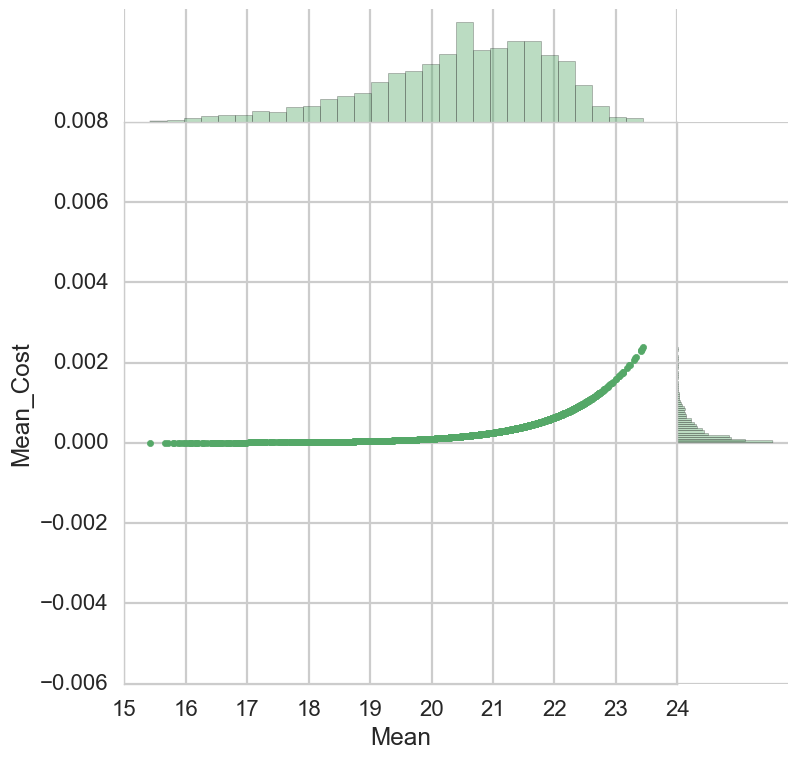

In [8]:
sns.jointplot(lab_set.Mean, lab_set.Mean_Cost, kind='scatter', 
              color='g', space=0, size=8, stat_func=None)
#plt.ylim(-1e-8, 1e-7)
#plt.yscale('log')
plt.show()

In [20]:
classes_H = list(set(lab_set.Var_Type.values))
print classes_H
lab_set['Class'] = np.nan
for k,clas in enumerate(classes_H):
    mask = (lab_set.Var_Type == clas)
    lab_set.loc[mask,'Class'] = k+1
lab_set['Class'] = lab_set['Class'].astype(int)
lab_set.head()

['SNe', 'QSO', 'EB', 'RRLYR', 'CV', 'NV']


,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Color,Con,Eta_e,...,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,RA,DEC,Var_Type,Mean_Cost,Class
ID,,,,,,,,,,,,,,,,,,,,,
Blind15A_46_S20_1254_3176,0.015950,0.999995,1.0,0.148148,31.778090,-1.878726e-10,0.594937,0.213417,0.0,107.595900,...,0.067394,10.090982,0.008049,0.669876,0.648062,158.627189,2.425190,CV,0.000037,5
Blind15A_04_N14_0631_2620,0.412700,0.876117,1.0,0.240000,5940.167922,-2.290278e+00,0.003741,0.672523,0.0,64.093646,...,0.067381,3.342968,0.208519,0.794607,0.694815,136.487914,-0.678517,CV,0.000775,5
Blind15A_04_N28_1472_0762,0.235575,0.986763,1.0,0.280000,8.241259,-3.151730e-02,2.690628,0.927960,0.0,21.277655,...,0.067381,2.121489,0.111137,0.726788,0.689516,137.594557,-1.069342,CV,0.000741,5
Blind15A_04_S26_0727_1544,0.229775,0.322748,1.0,0.240000,19.095625,3.913597e-02,1.158958,0.359028,0.0,35.961366,...,0.067381,0.488983,0.115685,0.826952,0.596905,137.031415,0.465540,CV,0.000712,5
Blind15A_05_N9_1616_2217,0.036275,0.440752,1.0,0.392857,33.966618,-1.010378e-09,0.594872,0.065593,0.0,142.498650,...,0.067383,-0.340324,0.021160,0.850193,0.786727,137.923154,1.413222,CV,0.000121,5


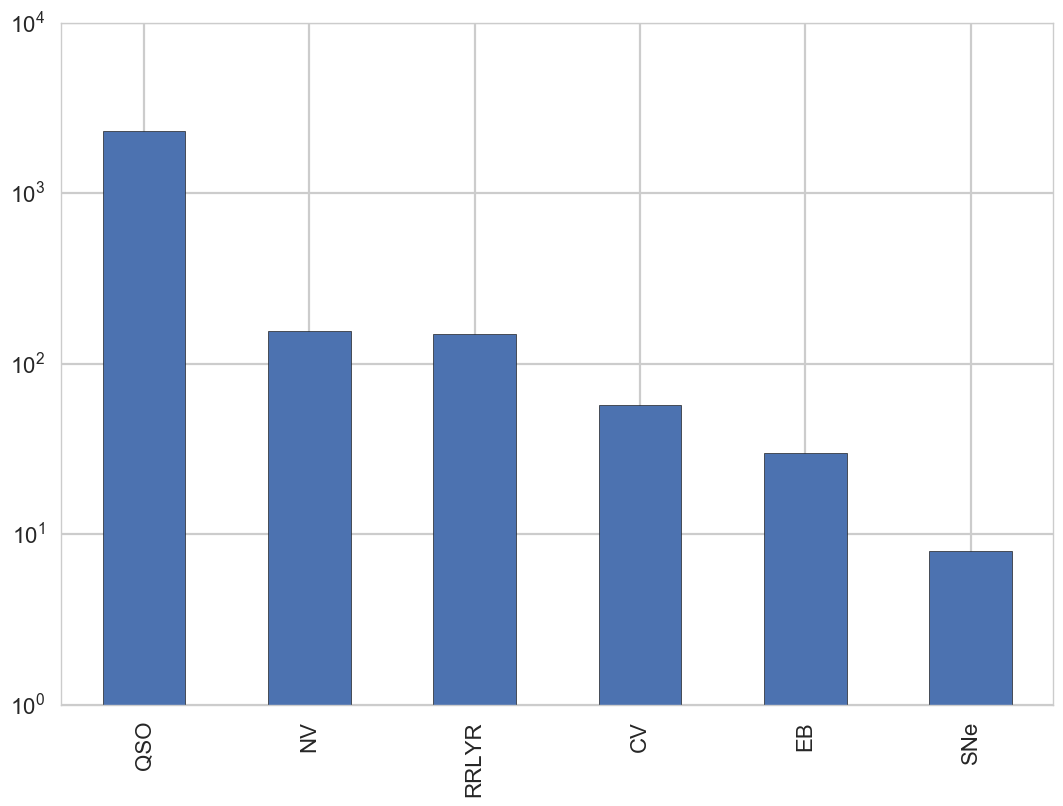

In [21]:
lab_set.Var_Type.value_counts().plot(kind="bar")
plt.yscale('log')
plt.show()

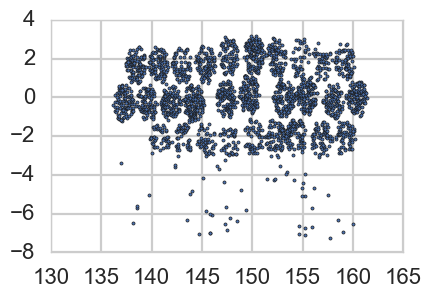

In [22]:
plt.figure(figsize = [10,3])
plt.subplot(1,2,1)
plt.scatter(lab_set['RA'],lab_set['DEC'], marker='.')
plt.show()

In [23]:
FEAT = lab_set.columns.tolist()[:61]
print FEAT

['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std', 'CAR_mean', 'CAR_sigma', 'CAR_tau', 'Color', 'Con', 'Eta_e', 'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35', 'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65', 'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0', 'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2', 'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_0', 'Freq1_harmonics_rel_phase_1', 'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3', 'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1', 'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3', 'Freq2_harmonics_rel_phase_0', 'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2', 'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0', 'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2', 'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_0', 'Freq3_harmonics_rel_phase_1', 'Freq3_harmonics_rel_phase_2', 'Freq3_harmonics_rel_

In [24]:
Xr, Xt, yr, yt = train_test_split(lab_set, lab_set.Class,
                                  train_size=2000, test_size=674, random_state=42)
Xinit, Xsearch, yinit, ysearch = train_test_split(Xr, yr, train_size=20,
                                                  test_size=1900, random_state=42)

Xinit_copy = Xinit.copy()
Xsearch_copy = Xsearch.copy()
Xr_copy = Xr.copy()
Xt_copy = Xt.copy()

yinit_copy = yinit.copy()
ysearch_copy = ysearch.copy()
yr_copy = yr.copy()
yt_copy = yt.copy()


## Test

In [25]:

initial_size = 20       # initial size of labeled instances S
num_pic = 10
num_kmean_class = 20    # batch size b?

num_loops = 5            # number of loop
N = 15                    # maximun number of iterations k_max
degree_list = [0.2,0.4,0.6,0.8,1.]

num_deg = len(degree_list)
uncertainty_thred = 1

acc_list_rf_best_mean = np.zeros((num_deg,num_loops,N))
time_cost_list_rf_best_mean = np.zeros((num_deg,num_loops,N))

begin = time.time()

for dk in xrange(num_deg):
    degree = degree_list[dk]
    print "degree: %.1f deg" % degree
    #if degree < 0.9: continue
    for j in xrange(num_loops):
        print '\tloop number: %i' % j
        #if j > 1: continue
        
        Xsearch = Xsearch_copy.copy()
        ysearch = ysearch_copy.copy()
        
        # inital labeled sets
        Xinit = Xinit_copy.copy()
        yinit = yinit_copy.copy() 
        
        # hole test set
        Xt = Xt_copy.copy()
        yt = yt_copy .copy()
        
        # inital labeled sets
        Xlabel = Xinit.copy()
        ylabel = yinit.copy()
        
        # caulculate uncertanties of classification from RF
        uncertainty_idx_list,uncertainty_score_list,acc_temp = \
                     get_uncertainty_by_ranfom_forest(Xinit[FEAT],yinit,
                                                      Xsearch[FEAT],Xt[FEAT],
                                                      yt,uncertainty_thred=1)
        #uncertainty_idx_list          # index of the uncertanty for every instance of RF prediction
        #uncertainty_score_list        # value of the uncertanty for every instance of RF prediction  
        #acc_temp                      # score of global predicion
        
        acc_list_rf_best_mean[dk,j,0] = acc_temp
        time_cost_list_rf_best_mean[dk,j,0] = 0

        # rejected obj (low certainty), Xre has the rejected elements
        Xre = Xsearch.drop(Xsearch.index[uncertainty_idx_list])
        yre = ysearch.drop(ysearch.index[uncertainty_idx_list])

        for i in xrange(N-1):
            print "\t\t iter = ", i
            
            # break si hay menos elementos en Xsearsh que numero de clusters buscados
            if(Xsearch.shape[0] < num_kmean_class): break
            # hace PCA de las features reduciendo a 10 componentes
            pca_data = PCA(n_components=10).fit_transform(Xsearch[FEAT])
            # k-means usando los features despues de PCA, numero de clusters = 20
            diversity_label_list, center_list = kmeans_labels(pca_data,num_kmean_class)

            # diversity_label_list        vector with labels per instance, with len = len(Xsearch)
            # center_list                 center of each cluster
            
            data_dist_list = data_dist_2_center_normal(pca_data,diversity_label_list,
                                                       center_list,num_kmean_class)
            # data_dist_list has the normalized distance of each instance respect to the,
            # center of their cluster this distance is normalized respect to the furthest
            # of each cluster

            pointing_table = pointing_by_object_whole_length_w_randomness(Xsearch[['RA','DEC']].values,
                                                                          degree)
            
            cluster_obj_table, cluster_score_table = \
                            cluster_obj_and_score_tabel_mean(diversity_label_list,
                                                             uncertainty_score_list,num_kmean_class)
            score_list = pointing_score_list(cluster_score_table,data_dist_list,pointing_table
                                             , diversity_label_list, uncertainty_score_list,
                                             Xsearch, mag_thred=0.85)
            
            #print score_list
            score_list_normalized, total_score_normalized,dom = score_normalization(score_list)
            first_pointing_idx = select_N_pointing_w_max(total_score_normalized, 1)
            
            combined_score_list = combined_pointing_score_list(Xsearch, pointing_table,
                                                               first_pointing_idx, mag_thred=0.85)
            
            score_list_normalized, total_score_normalized,dom = score_normalization(combined_score_list)
            second_pointing_idx = select_N_pointing_w_max(total_score_normalized, 1)
            score_prev = total_score_normalized[second_pointing_idx][0]
            idx_prev = [first_pointing_idx[0], second_pointing_idx[0]]
            
            idx_new,score_new,time_new = simulating_annealing(dom, Xsearch,idx_prev,score_prev,
                                                              pointing_table,10.0, 0.95, 10,1000)
            
            selected_obj_list = np.unique(pointing_table[idx_new[0]]+pointing_table[idx_new[1]])
            
            # hera are the selected objecs to observe?
            X_selected = Xsearch.iloc[selected_obj_list]
            y_selected = ysearch.iloc[selected_obj_list]
            
            print 'new candidates: %i' % X_selected.shape[0]

            Xlabel = pd.concat([Xlabel,X_selected], axis=0)   
            ylabel = pd.concat([ylabel,y_selected], axis=0)

            # remove selected objects from search set
            Xsearch.drop(Xsearch.index[selected_obj_list], inplace=True)
            ysearch.drop(ysearch.index[selected_obj_list], inplace=True)
            if(Xsearch.shape[0] < num_kmean_class): break

            # fill the uncertainties matrix with update values after the selected instances are added
            uncertainty_idx_list,uncertainty_score_list,acc_temp =\
                        get_uncertainty_by_ranfom_forest(Xlabel[FEAT],ylabel,
                                                         Xsearch[FEAT],Xt[FEAT],
                                                         yt,uncertainty_thred=1)
            acc_list_rf_best_mean[dk,j,i+1] = acc_temp
            time_cost_list_rf_best_mean[dk,j,i+1] = time_new
            
    print '______________________________'
            
            
print 'Time Elapsed:', time.time()-begin 

degree: 0.2 deg
	loop number: 0
		 iter =  0
new candidates: 17
		 iter =  1
new candidates: 5
		 iter =  2
new candidates: 17
		 iter =  3
new candidates: 12
		 iter =  4
new candidates: 9
		 iter =  5
new candidates: 9
		 iter =  6
new candidates: 13
		 iter =  7
new candidates: 5
		 iter =  8
new candidates: 10
		 iter =  9
new candidates: 11
		 iter =  10
new candidates: 12
		 iter =  11
new candidates: 7
		 iter =  12
new candidates: 16
		 iter =  13
new candidates: 9
	loop number: 1
		 iter =  0
new candidates: 14
		 iter =  1
new candidates: 10
		 iter =  2
new candidates: 16
		 iter =  3
new candidates: 9
		 iter =  4
new candidates: 10
		 iter =  5
new candidates: 7
		 iter =  6
new candidates: 16
		 iter =  7
new candidates: 29
		 iter =  8
new candidates: 17
		 iter =  9
new candidates: 6
		 iter =  10
new candidates: 14
		 iter =  11
new candidates: 9
		 iter =  12
new candidates: 13
		 iter =  13
new candidates: 22
	loop number: 2
		 iter =  0
new candidates: 15
		 iter = 

(5, 5, 15)


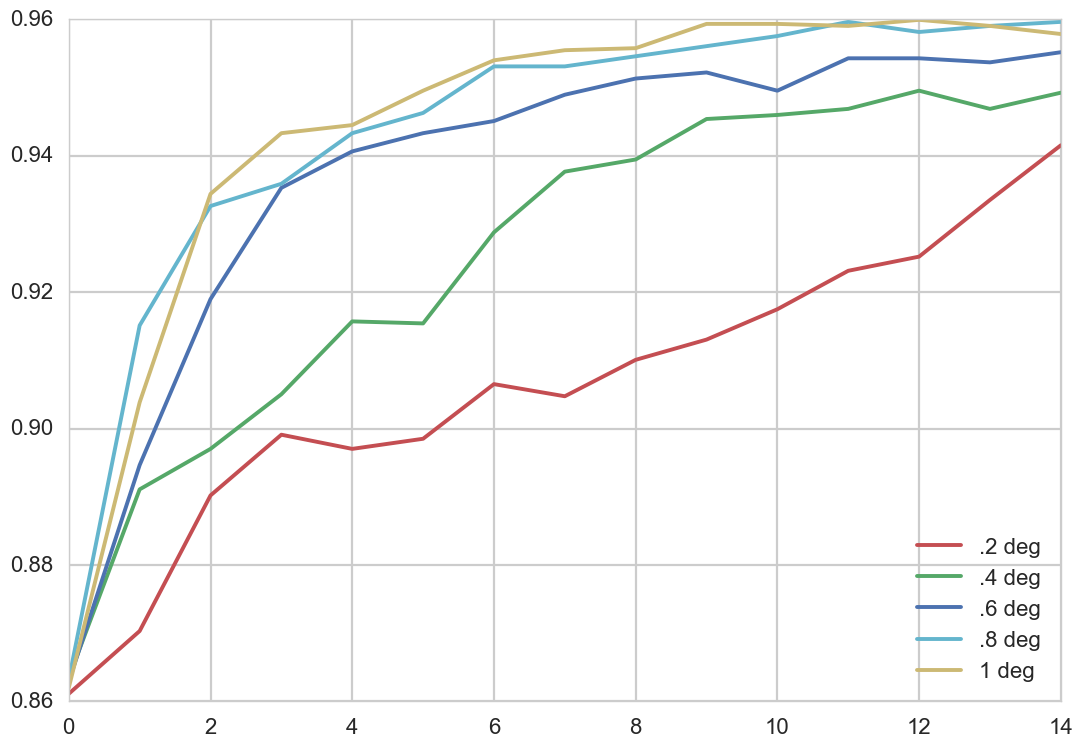

In [26]:
print acc_list_rf_best_mean.shape
plt.plot(acc_list_rf_best_mean[0].mean(axis=0),c='r', label='.2 deg')
plt.plot(acc_list_rf_best_mean[1].mean(axis=0),c='g', label='.4 deg')
plt.plot(acc_list_rf_best_mean[2].mean(axis=0),c='b', label='.6 deg')
plt.plot(acc_list_rf_best_mean[3].mean(axis=0),c='c', label='.8 deg')
plt.plot(acc_list_rf_best_mean[4].mean(axis=0),c='y', label='1 deg')
plt.legend(loc='best')
plt.show()

# New candidates for HiTS

In [40]:
target_set = pd.read_csv('/Users/jorgetil/Astro/HITS/tables/Blind15A_tables+feat_pl_var_type_spCL_spClass.csv',
                         index_col=0)
target_set.head()

,DEC,ELLIPTICITY,FLAGS,FLUX_RADIUS,FWHM,KRON_RADIUS,Median_err_g,Median_err_r,Median_g,Median_r,...,StetsonK,StetsonK_AC,WMCC_Period,WMCC_conf,spCl,subClass,Var_Type,Var_Type_ts,Var_subType,Pred_Var_Type
ID,,,,,,,,,,,,,,,,,,,,,
Blind15A_46_S20_1254_3176,2.425190,0.057493,0,2.516,4.75,3.50,0.034918,0.037848,18.907889,18.692564,...,0.669876,0.648062,0.011798,0.622819,STAR,CV,CV,CV,NaN,NaN
Blind15A_04_N14_0631_2620,-0.678517,0.082569,0,2.574,6.01,3.67,0.100049,0.158106,22.206085,21.524474,...,0.794607,0.694815,0.023370,0.616291,STAR,CV,CV,CV,NaN,NaN
Blind15A_04_N28_1472_0762,-1.069342,0.070632,0,2.445,5.83,3.50,0.092063,0.089440,22.159511,21.215743,...,0.726788,0.689516,0.025218,0.572794,STAR,CV,CV,CV,NaN,NaN
Blind15A_04_S26_0727_1544,0.465540,0.096658,0,2.743,6.22,3.50,0.099348,0.134971,22.143841,21.772031,...,0.826952,0.596905,0.014008,0.618837,STAR,CV,CV,CV,NaN,NaN
Blind15A_05_N9_1616_2217,1.413222,0.052132,0,2.533,4.53,3.50,0.042053,0.048256,20.206192,20.147795,...,0.850193,0.786727,0.016648,0.768001,STAR,CV,CV,CV,NaN,NaN


In [48]:
target_set = target_set[target_set['Var_Type_ts'].isnull()]
target_set_1000 = target_set.sample(10000)

In [49]:
features = target_set.columns[17:78]
target_set = target_set.dropna(subset=features)
tar_set = target_set[features].copy()
tar_set['RA'] = target_set['RA']
tar_set['DEC'] = target_set['DEC']
tar_set['Mean_Cost'] = np.power(10, 0.4*tar_set.Mean.values) / (1e15)
tar_set['Var_Type'] = target_set['Var_Type']
NN = tar_set.shape[0]
tar_set.head()

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Color,Con,Eta_e,...,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,RA,DEC,Mean_Cost,Var_Type
ID,,,,,,,,,,,,,,,,,,,,,
Blind15A_45_N15_0802_2683,1.166875,0.999999,5.0,0.565217,6.756564,-7.196844e-01,2.351377,0.165405,0.0,4.000133,...,0.277358,1.749873,-1.636676,0.934787,0.940212,0.861377,156.433041,1.469145,2.264082e-09,NaN
Blind15A_04_N1_0200_3669,0.062100,0.982491,1.0,0.208333,31.337537,-1.194232e-09,0.595079,1.277167,0.0,27.017940,...,-1.347254,0.067695,4.622367,0.035517,0.799796,0.720274,136.409581,-0.318287,2.879519e-08,NaN
Blind15A_04_N2_0800_0671,0.339625,0.292086,1.0,0.238095,35.828306,-5.698658e-09,0.595441,2.177610,0.0,50.476845,...,-0.258668,0.067594,1.905310,0.183435,0.764083,0.721033,136.500720,-0.362119,3.415522e-07,NaN
Blind15A_04_N2_1225_2873,0.084375,0.986259,1.0,0.200000,30.565922,-1.832883e-09,0.594807,1.521657,0.0,24.522770,...,-0.483703,0.067381,4.654949,0.041314,0.717752,0.613068,136.661381,-0.393330,1.872102e-08,NaN
Blind15A_04_N2_0159_3658,0.376250,0.998300,1.0,0.263158,8.593402,-9.398782e-02,2.499051,2.326619,0.0,20.374172,...,0.627633,0.067594,-0.460568,0.221511,0.901522,0.777360,136.718903,-0.315401,3.891715e-07,NaN


#### Seting search and initial dataset

In [50]:
import sklearn
print sklearn.__version__

0.18


In [52]:
# split in test set and training set using labeled data
Xr, Xt, yr, yt = train_test_split(lab_set, lab_set.Class,
                                  train_size=.6, test_size=.4)

# the initial labeled data will be the partial set
# the 'train_set from above'
Xinit = Xr.copy()
yinit = yr.copy()

# the search group will be the target set
Xsearch = tar_set.sample(500)
#ysearch = tar_set.sample(500)

Xinit_copy = Xinit.copy()
Xsearch_copy = Xsearch.copy()
Xr_copy = Xr.copy()
Xt_copy = Xt.copy()

yinit_copy = yinit.copy()
#ysearch_copy = ysearch
yr_copy = yr.copy()
yt_copy = yt.copy()

print Xr.shape
print Xt.shape
print Xinit.shape
print Xsearch.shape


(1626, 66)
(1084, 66)
(1626, 66)
(500, 65)


In [53]:
initial_size = int(Xinit.shape[0])       # initial size of labeled instances S
num_pic = 10
num_kmean_class = 20    # batch size b?
N = 15

degree_list = [0.2,0.4,0.6,0.8,1.]

num_deg = len(degree_list)
uncertainty_thred = 1

new_candidates = []

begin = time.time()

for dk in xrange(num_deg):
    degree = degree_list[dk]
    print "degree: %.1f deg" % degree
    
    Xsearch = Xsearch_copy.copy()
    #ysearch = ysearch_copy.copy()
    
    # inital labeled sets
    Xinit = Xinit_copy.copy()
    yinit = yinit_copy.copy() 
    
    # hole test set
    Xt = Xt_copy.copy()
    yt = yt_copy .copy()
    
    # inital labeled sets
    Xlabel = Xinit.copy()
    ylabel = yinit.copy()
    
    # caulculate uncertanties of classification from RF
    uncertainty_idx_list,uncertainty_score_list,acc_temp = \
                 get_uncertainty_by_ranfom_forest(Xinit[FEAT],yinit,
                                                  Xsearch[FEAT],Xt[FEAT],
                                                  yt,uncertainty_thred=1)
    print 'Initial accuracy: %f' % acc_temp
    #uncertainty_idx_list          # index of the uncertanty for every instance of RF prediction
    #uncertainty_score_list        # value of the uncertanty for every instance of RF prediction  
    #acc_temp                      # score of global predicion

    # rejected obj (low certainty), Xre has the rejected elements
    Xre = Xsearch.drop(Xsearch.index[uncertainty_idx_list])
    #yre = ysearch.drop(ysearch.index[uncertainty_idx_list])

    for i in xrange(N-1):
        print "\t\t iter = ", i
        
        # break si hay menos elementos en Xsearsh que numero de clusters buscados
        if(Xsearch.shape[0] < num_kmean_class): break
        # hace PCA de las features reduciendo a 10 componentes
        pca_data = PCA(n_components=10).fit_transform(Xsearch[FEAT])
        # k-means usando los features despues de PCA, numero de clusters = 20
        diversity_label_list, center_list = kmeans_labels(pca_data,num_kmean_class)

        # diversity_label_list        vector with labels per instance, with len = len(Xsearch)
        # center_list                 center of each cluster
        
        data_dist_list = data_dist_2_center_normal(pca_data,diversity_label_list,
                                                   center_list,num_kmean_class)
        # data_dist_list has the normalized distance of each instance respect to the,
        # center of their cluster this distance is normalized respect to the furthest
        # of each cluster

        pointing_table = pointing_by_object_whole_length_w_randomness(Xsearch[['RA','DEC']].values,
                                                                      degree)
        
        cluster_obj_table, cluster_score_table = \
                        cluster_obj_and_score_tabel_mean(diversity_label_list,
                                                         uncertainty_score_list,num_kmean_class)
        score_list = pointing_score_list(cluster_score_table,data_dist_list,pointing_table
                                         , diversity_label_list, uncertainty_score_list,
                                         Xsearch, mag_thred=0.85)
        
        #print score_list
        score_list_normalized, total_score_normalized,dom = score_normalization(score_list)
        first_pointing_idx = select_N_pointing_w_max(total_score_normalized, 1)
        
        combined_score_list = combined_pointing_score_list(Xsearch, pointing_table,
                                                           first_pointing_idx, mag_thred=0.85)
        
        score_list_normalized, total_score_normalized,dom = score_normalization(combined_score_list)
        second_pointing_idx = select_N_pointing_w_max(total_score_normalized, 1)
        score_prev = total_score_normalized[second_pointing_idx][0]
        idx_prev = [first_pointing_idx[0], second_pointing_idx[0]]
        
        idx_new,score_new,time_new = simulating_annealing(dom, Xsearch,idx_prev,score_prev,
                                                          pointing_table,10.0, 0.95, 10,1000)
        
        selected_obj_list = np.unique(pointing_table[idx_new[0]]+pointing_table[idx_new[1]])
        
        # here are the selected objecs to observe
        X_selected = Xsearch.iloc[selected_obj_list]
        #y_selected = ysearch.iloc[selected_obj_list]
        new_candidates.append(X_selected)
        
        print 'new candidates: %i' % X_selected.shape[0]

        # remove selected objects from search set
        Xsearch.drop(Xsearch.index[selected_obj_list], inplace=True)
        #ysearch.drop(ysearch.index[selected_obj_list], inplace=True)
        
        if(Xsearch.shape[0] < num_kmean_class): break
        break
            
    print '______________________________'
            
            
print 'Time Elapsed:', time.time()-begin 

degree: 0.2 deg
Initial accuracy: 0.958487
		 iter =  0


/Users/jorgetil/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


new candidates: 6
______________________________
degree: 0.4 deg
Initial accuracy: 0.957565
		 iter =  0
new candidates: 6
______________________________
degree: 0.6 deg
Initial accuracy: 0.957565
		 iter =  0
new candidates: 14
______________________________
degree: 0.8 deg
Initial accuracy: 0.954797
		 iter =  0
new candidates: 24
______________________________
degree: 1.0 deg
Initial accuracy: 0.955720
		 iter =  0
new candidates: 29
______________________________
Time Elapsed: 9.84574604034


In [54]:
new_candidates_ = pd.concat(new_candidates, axis=0, join='inner').drop_duplicates()
new_candidates_.shape

(55, 65)

In [56]:
RFC = RandomForestClassifier(n_estimators=1000, criterion='gini',
                           max_features='sqrt', max_depth=10, n_jobs=2,
                            min_samples_leaf=1, oob_score=True)
RFC.fit(lab_set[FEAT], lab_set.Var_Type)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=2, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [58]:
clases = RFC.classes_
predicted_proba = RFC.predict_proba(new_candidates_[FEAT])
new_candidates_['Var_Type_pred'] = RFC.predict(new_candidates_[FEAT])

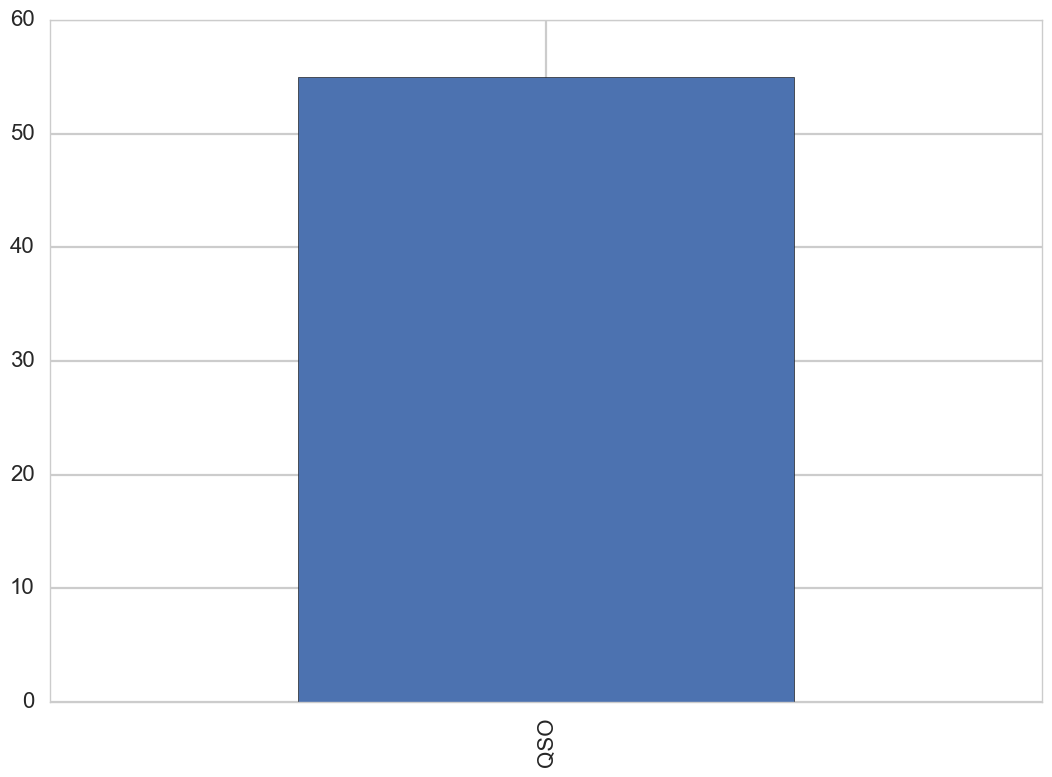

(55, 6)


In [59]:
new_candidates_.Var_Type_pred.value_counts().plot(kind="bar")
plt.show()
print predicted_proba.shape

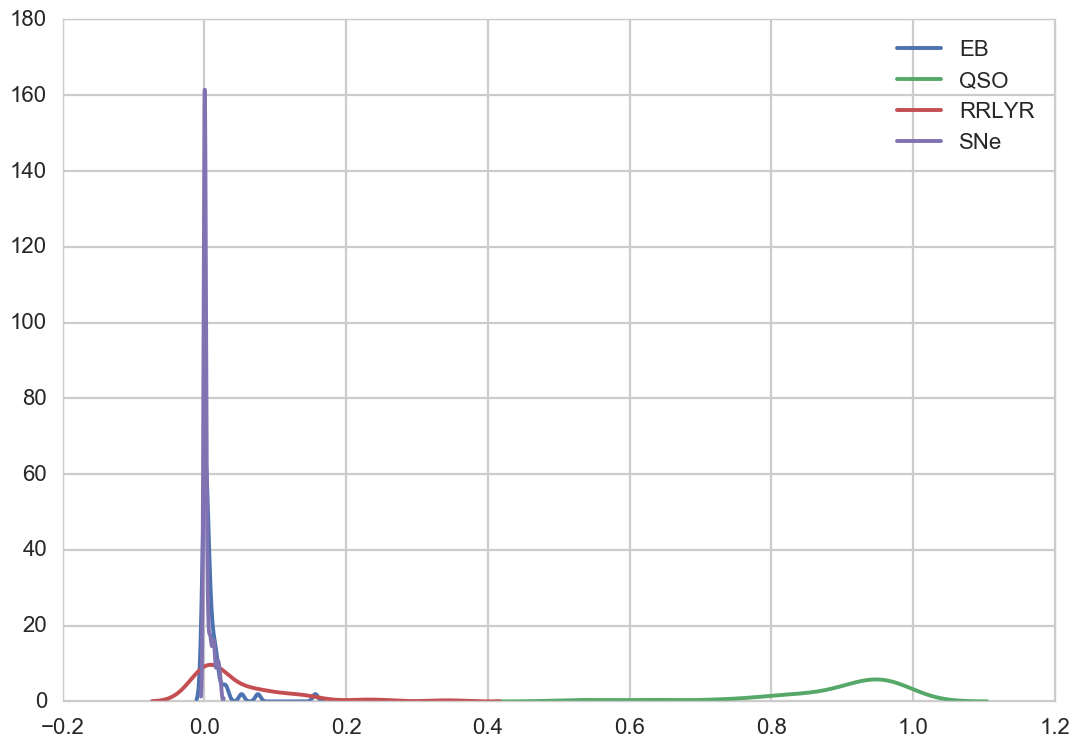

In [62]:
#sns.distplot(predicted_proba[:,0], hist=False, kde=True, label=clases[0])
sns.distplot(predicted_proba[:,1], hist=False, kde=True, label=clases[1])
#sns.distplot(predicted_proba[:,2], hist=False, kde=True, label=clases[2])
sns.distplot(predicted_proba[:,3], hist=False, kde=True, label=clases[3])
sns.distplot(predicted_proba[:,4], hist=False, kde=True, label=clases[4])
sns.distplot(predicted_proba[:,5], hist=False, kde=True, label=clases[5])
#sns.distplot(predicted_proba[:,6], hist=False, kde=True, label=clases[6])
plt.show()

In [299]:
new_candidates[-1].to_csv('/Users/jorgetil/Astro/HITS/tables/Blind15A_candidates_AL.csv')